# Retrofit to a subgraph extracted from the Roam Health Knowledge Graph

In [5]:
import numpy as np
import scipy
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import normalize
import time

import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '../../'))
from retrofit_identity import retrofit_identity
from retrofit_linear   import retrofit_linear
from utils import *

In [6]:
X = load_obj("X_dim_10")
retrofit_edges = load_obj("retrofit_edges")
retrofit_edges_out = load_obj("retrofit_edges_out")

print("X shape: {}".format(X.shape))
X = normalize(X, norm='l2')

print("="*80 + "\nIdentity Retrofitting")
t = time.time()
X_ide = retrofit_identity(
    X, retrofit_edges, alpha=lambda i: 0.1, n_iter=20, verbose=True)
print("Took {:.2f} seconds.".format(time.time() - t))
print("="*80 + "\nLinear Retrofitting")
t = time.time()
X_lin, A, B = retrofit_linear(
    X, retrofit_edges, retrofit_edges_out, orthogonal=True,
    n_iter=100, lam=1e-5, lr=1.0, lr_decay=0.99,
    tol=1e-5, alpha=lambda i: 0.1, verbose=True)
print("Linear took {:.2f} seconds.".format(time.time() - t))

X shape: (3370, 10)
Identity Retrofitting
Converged at iteration 18
Took 1.54 seconds.
Linear Retrofitting
Iteration 1 of 100	Changes: 34.370	Loss: 1470.028
Iteration 2 of 100	Changes: 19.857	Loss: 764.443
Iteration 3 of 100	Changes: 10.375	Loss: 743.719
Iteration 4 of 100	Changes: 8.976	Loss: 574.955
Iteration 5 of 100	Changes: 2.132	Loss: 516.023
Iteration 6 of 100	Changes: 3.140	Loss: 465.037
Iteration 7 of 100	Changes: 1.344	Loss: 438.895
Iteration 8 of 100	Changes: 1.718	Loss: 413.074
Iteration 9 of 100	Changes: 1.370	Loss: 395.542
Iteration 10 of 100	Changes: 1.424	Loss: 380.570
Iteration 11 of 100	Changes: 1.417	Loss: 368.724
Iteration 12 of 100	Changes: 1.369	Loss: 356.527
Iteration 13 of 100	Changes: 1.218	Loss: 345.165
Iteration 14 of 100	Changes: 1.054	Loss: 335.279
Iteration 15 of 100	Changes: 0.908	Loss: 327.618
Iteration 16 of 100	Changes: 0.826	Loss: 321.852
Iteration 17 of 100	Changes: 0.735	Loss: 317.236
Iteration 18 of 100	Changes: 0.659	Loss: 312.233
Iteration 19 of 

In [17]:
# Train Classifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import classification_report
clf_edges = load_obj('clf_edges')
index_by_name = load_obj('index_by_name')

def print_top_n_not_annotated(top_n, probs, Y_test, index_by_name, test_indices):
    probs = probs[:, 1]
    i = 0
    name_by_index = {}
    for name, index in index_by_name.items():
        name_by_index[index] = name

    probs_sorted = sorted(enumerate(probs), key=lambda x: x[1], reverse=True)
    for (index, prob) in probs_sorted:
        if i >= top_n:
            break
        if Y_test[index] == 0:
            i += 1
            print("Predicted drug '{}' TREATS '{}' with score: {:.4f}.".format(name_by_index[test_indices[index][0]], 
                                                                     name_by_index[test_indices[index][1]],
                                                                     prob))

def print_predictions(models, X_test, Y_test, index_by_name, test_indices):
    for model in models:
        print('-'*20)
        probs = model.predict_proba(X_test)
        print_top_n_not_annotated(15, probs, Y_test, index_by_name, test_indices)
            
scaler = StandardScaler()
p_train = 0.8
train_indices, test_indices, neg_train_indices, neg_test_indices = get_train_test_indices(
    clf_edges, p_train)

Y_train = np.ones(len(train_indices))
Y_train = np.concatenate((Y_train, np.zeros((len(neg_train_indices), ))))
Y_test = np.ones(len(test_indices))
Y_test = np.concatenate((Y_test, np.zeros((len(neg_test_indices), ))))
train_indices.extend(neg_train_indices)
test_indices.extend(neg_test_indices)
make_train = lambda rep: np.array([np.hstack((rep[i], rep[j])) for (i,j) in train_indices])
make_test = lambda rep: np.array([np.hstack((rep[i], rep[j])) for (i,j) in test_indices])
def make_train_lin(rep):
    ar = []
    for (i,j) in train_indices:
        a = rep[j]
        b = rep[i]
        ar.append(np.hstack((a, b)))
    return np.array(ar)
def make_test_lin(rep):
    ar = []
    for (i,j) in test_indices:
        a = rep[j]
        b = rep[i]
        ar.append(np.hstack((a, b)))
    return np.array(ar)

print("="*40 + "\nAccuracies for Edges of Type 'Treats': (# training: {}, # testing: {})".format(
    len(Y_train), len(Y_test)))

# Dummy
X_normalized = scaler.fit_transform(X)
X_train_raw = make_train(X_normalized)
X_test_raw = make_test(X_normalized)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_raw, Y_train)
print("Dummy: {:.4f}".format(dummy.score(X_test_raw, Y_test)))

rf = RandomForestClassifier(n_estimators=50, criterion='entropy')

# Distributional Data
print("="*80+"\nDistributional: ")
rf.fit(X_train_raw, Y_train)
print("RF\tAccuracy: {:.4f}".format(rf.score(X_test_raw, Y_test)))
print(classification_report(Y_test, rf.predict(X_test_raw),
                            target_names=['Edge Exists', 'Edge Does Not Exist']))
print_predictions([rf], X_test_raw, Y_test, index_by_name, test_indices)

# Identity Retrofitting
print("="*80 + "\nIdentity Retrofitting:")
X_ide_normalized = scaler.fit_transform(X_ide) # TODO: check if this makes a difference
X_train_ide = make_train(X_ide_normalized)
X_test_ide  = make_test(X_ide_normalized)
rf.fit(X_train_ide, Y_train)
print("RF\tAccuracy: {:.4f}".format(rf.score(X_test_ide, Y_test)))
print(classification_report(Y_test, rf.predict(X_test_ide),
                            target_names=['Edge Exists', 'Edge Does Not Exist']))
print_predictions([rf], X_test_ide, Y_test, index_by_name, test_indices)

# Linear Retrofitting
print("="*80 + "\nLinear Retrofitting:")
X_lin_normalized = scaler.fit_transform(np.squeeze(X_lin))
X_train_lin = make_train_lin(X_lin_normalized)
X_test_lin = make_test_lin(X_lin_normalized)
rf.fit(X_train_lin, Y_train)
print("RF Accuracy:\t{:.4f}".format(rf.score(X_test_lin, Y_test)))
print(classification_report(Y_test, rf.predict(X_test_lin),
                            target_names=['Edge Exists', 'Edge Does Not Exist']))
print_predictions([rf], X_test_lin, Y_test, index_by_name, test_indices)

Accuracies for Edges of Type 'Treats': (# training: 9036, # testing: 2606)
Dummy: 0.5000
Distributional: 
RF	Accuracy: 0.7391
                     precision    recall  f1-score   support

        Edge Exists       0.71      0.80      0.75      1303
Edge Does Not Exist       0.77      0.68      0.72      1303

        avg / total       0.74      0.74      0.74      2606

--------------------
Predicted drug 'exforge' TREATS 'Athscl heart disease of native coronary artery w/o ang pctrs' with score: 1.0000.
Predicted drug 'tribenzor' TREATS 'Chronic passive congestion of liver' with score: 1.0000.
Predicted drug 'acetylcysteine' TREATS 'Hemophilus influenzae infection, unspecified site' with score: 0.9600.
Predicted drug 'doxepin' TREATS 'Major depressive disorder, recurrent' with score: 0.9200.
Predicted drug 'nifedipine' TREATS 'Unstable angina' with score: 0.9200.
Predicted drug 'toprol' TREATS 'Heart failure, unspecified' with score: 0.9200.
Predicted drug 'trazodone' TREATS 'Generaliz

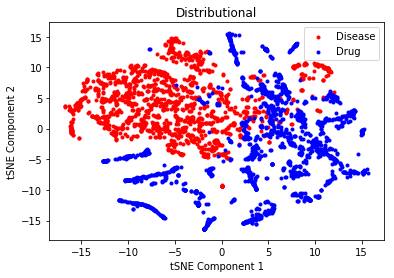

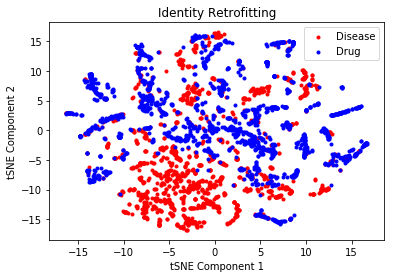

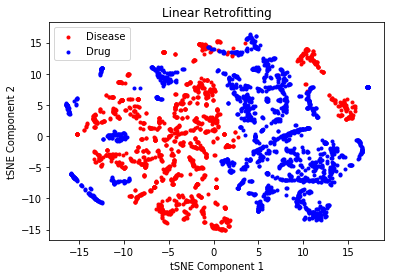

In [20]:
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt

def plot(X, title, n_diseases=1568, n_iter=200):
    t = TSNE(n_iter=n_iter)
    X_tsne = t.fit_transform(X)
    plt.scatter(X_tsne[:n_diseases, 0], X_tsne[:n_diseases, 1], color='r', marker='.')
    plt.scatter(X_tsne[n_diseases:, 0], X_tsne[n_diseases:, 1], color='b', marker='.')
    plt.legend(['Disease', 'Drug'])
    plt.title(title)
    plt.xlabel("tSNE Component 1")
    plt.ylabel("tSNE Component 2")
    plt.show()

plot(X,     'Distributional')
plot(X_ide, 'Identity Retrofitting')
plot(X_lin, 'Linear Retrofitting')